https://adventofcode.com/2022/day/23

In [1]:
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, Self
from utilities import xy_array_as_string
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def load_data(filename):
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
    return [list(line) for line in lines]

nswe = {'N': np.array([0, -1]),
        'S': np.array([0, 1]),
        'W': np.array([-1, 0]),
        'E': np.array([1, 0])}

direction_mapping = {'N': (1, -1),
                     'S': (1, 1),
                     'W': (0, -1),
                     'E': (0, 1)} # first number is axis, second is direction

@dataclass
class Elf():
    loc: np.ndarray
    proposed_move: Optional[str] = None
    neighbour_locs: Optional[list[Self]] = None
    _neighbourhood: Optional[tuple[tuple[int, int]]] = None
    n_turns: int = 0
        
    @property
    def target(self) -> Optional[np.ndarray]:
        if self.proposed_move:
            return self.loc + nswe[self.proposed_move]
        else:
            return None
        
    def move(self) -> int:
        if self.target is None:
            return 0
        else:
            self.loc = self.target
            self.proposed_move = None
            return 1
            
    @property
    def neighbourhood(self) -> tuple[tuple[int, int]]:
        if self._neighbourhood is None:
            self._neighbourhood = ((self.loc[0]+1, self.loc[1]+1),
                                   (self.loc[0],   self.loc[1]+1),
                                   (self.loc[0]-1, self.loc[1]+1),
                                   (self.loc[0]+1, self.loc[1]),
                                   (self.loc[0]-1, self.loc[1]),
                                   (self.loc[0]+1, self.loc[1]-1),
                                   (self.loc[0],   self.loc[1]-1),
                                   (self.loc[0]-1, self.loc[1]-1))
        return self._neighbourhood
    
    def propose_move(self,
                     direction_check: dict) -> None:
        if len(self.neighbour_locs) == 0:
            self.proposed_move = None
        else:
            n_locs = self.neighbour_locs - self.loc
            for dc in direction_check:
                d = direction_mapping[dc]
                if np.all(n_locs[:,d[0]] - d[1] != 0):
                    self.proposed_move = dc
                    break
                    
    def reset(self) -> None:
        self.proposed_move = None
        self.neighbour_locs = None
        self._neighbourhood = None

@dataclass
class ElfCollection():
    elves: tuple[Elf]
    direction_check: deque=field(init=False)
    _locs: Optional[np.ndarray] = None
    _locs_set: Optional[set] = None
        
    def __post_init__(self) -> None:
        self.direction_check = deque(['N', 'S', 'W', 'E'])
        
    @property
    def locs(self) -> np.ndarray:
        if self._locs is None:
            self._locs = np.array([elf.loc for elf in self.elves])
        return self._locs
    
    @property
    def locs_set(self) -> tuple[tuple[int, int]]:
        if self._locs_set == None:
            self._locs_set = set(tuple(loc) for loc in self.locs)
        return self._locs_set
        
    def assign_neighbours(self) -> None:
        for elf in self.elves:
            elf.neighbour_locs = np.array(list(set.intersection(set(elf.neighbourhood), 
                                                           self.locs_set)))
            
    def assign_moves(self) -> None:
        for elf in self.elves:
            elf.propose_move(self.direction_check)
        u, c = np.unique([e.target for e in self.elves if e.target is not None],
                         axis=0,
                         return_counts=True)
        destination_counter = {}
        for a, b in zip(u, c):
            destination_counter[tuple(a)] = b
        for elf in self.elves:
            if elf.target is not None:
                if destination_counter[tuple(elf.target)] > 1:
                    elf.proposed_move = None
                    
    def move(self) -> None:
        n_moves = sum(elf.move() for elf in self.elves)
        self._locs = None
        self._locs_set = None
        return n_moves
            
    def end_of_turn(self) -> None:
        self.direction_check.rotate(-1)
        for e in elves:
            e.reset()
            
    def __getitem__(self,
                     i: int) -> Elf:
        return self.elves[i]
    
    def show(self) -> str:
        shifted_locs = self.locs - np.min(self.locs, axis=0)
        m = np.zeros(np.max(shifted_locs, axis=0)+1)
        for loc in shifted_locs:
            m[tuple(loc)] = 1
        return m
        
    def solve(self,
              n_turns: int=10000,
              display: bool=False) -> None:
        i = 0
        while i < n_turns:
            i += 1
            self.n_turns = i
            self.assign_neighbours()
            self.assign_moves()
            n_moves = self.move()
            if n_moves == 0:
                break
            self.end_of_turn()
            if display:
                self.matshow()
            
    def matshow(self) -> None:
            clear_output(wait=True)
            plt.matshow(self.show())
            plt.axis('off')
            plt.show()
            
    def size(self) -> int:
        return np.product(np.max(self.locs, axis=0) - np.min(self.locs, axis=0) + np.array([1,1])) - len(self.elves)


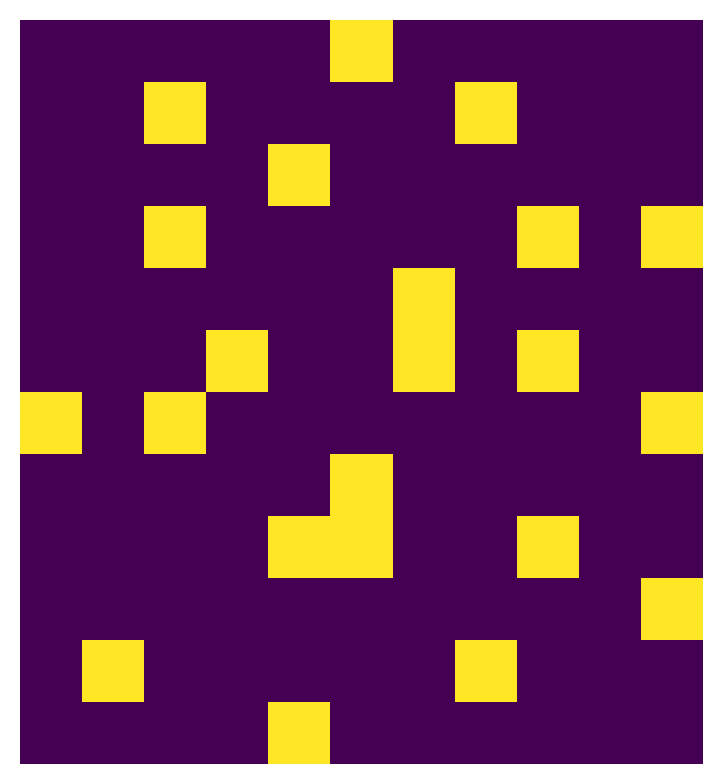

110

In [2]:
filename = "../example_data/day23_example_data.txt"
data = load_data(filename)
elves = []
for y, row in enumerate(data):
    for x, s in enumerate(row):
        if s == '#':
            elves.append(Elf(loc=np.array([x, y])))
elves = ElfCollection(elves)
elves.solve(10, display=True)
elves.size()

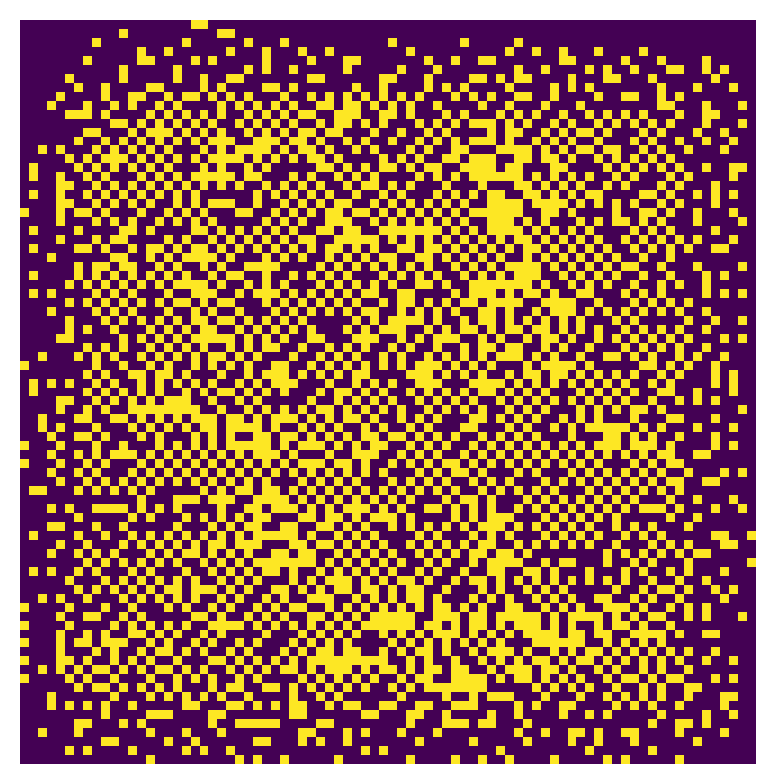

4181

In [3]:
filename = "../data/day23_data.txt"
data = load_data(filename)
elves = []
for y, row in enumerate(data):
    for x, s in enumerate(row):
        if s == '#':
            elves.append(Elf(loc=np.array([x, y])))
elves = ElfCollection(elves)
elves.solve(10, display=True)
elves.size()

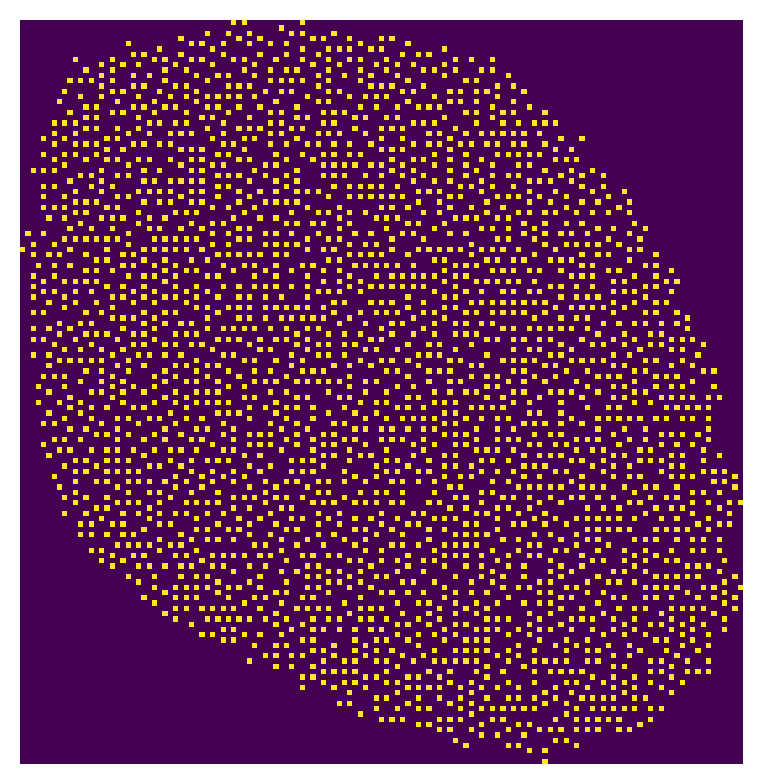

973

In [4]:
filename = "../data/day23_data.txt"
data = load_data(filename)
elves = []
for y, row in enumerate(data):
    for x, s in enumerate(row):
        if s == '#':
            elves.append(Elf(loc=np.array([x, y])))
elves = ElfCollection(elves)
elves.solve(display=True)
elves.n_turns